In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
import skcosmo.sample_selection
import sklearn
import scipy
import copy

import ase.io

from aml_rascal_bridge import RascalSphericalExpansionTorch, TorchFrame
from aml_storage import Labels, Block, Descriptor

In [2]:
frames = ase.io.read("data/molecule_conformers_dftb.xyz", ":100")

# frames = ase.io.read("selection-10k.extxyz", "::100")
# for frame in frames:
#     frame.cell = [100, 100, 100]
#     frame.center

training_frames_np, testing_frames_np = sklearn.model_selection.train_test_split(
    frames, train_size=0.8, random_state=0XDEADBEEF, 
)
del frames

train_energies = torch.tensor([
    frame.info["energy"] for frame in training_frames_np
])

train_forces = torch.vstack([
    torch.tensor(frame.arrays["forces"]) for frame in training_frames_np
])

test_energies = torch.tensor([
    frame.info["energy"] for frame in testing_frames_np
])

test_forces = torch.vstack([
    torch.tensor(frame.arrays["forces"]) for frame in testing_frames_np
])

# transform frames from numpy to torch:
training_frames = [TorchFrame(frame, requires_grad=True) for frame in training_frames_np]
testing_frames = [TorchFrame(frame, requires_grad=True) for frame in testing_frames_np]

In [3]:
rascal_hypers = {
    "interaction_cutoff": 3.5,
    "cutoff_smooth_width": 0.5,
    "max_radial": 6,
    "max_angular": 6,
    "gaussian_sigma_type": "Constant",
    "compute_gradients": True,
}

calculator = RascalSphericalExpansionTorch(rascal_hypers)

In [4]:
def invariant_block_to_2d_array(block):
    assert len(block.values.shape) == 3
    assert block.values.shape[1] == 1

    return block.values.reshape(block.values.shape[0], -1)

def array_2d_to_invariant(array):
    assert len(array.shape) == 2

    return array.reshape(array.shape[0], 1, -1)

In [5]:
def compute_power_spectrum(frames):
    spherical_expansion = calculator.compute(frames)
    assert spherical_expansion.sparse.names == ('spherical_harmonics_l', 'center_species', 'neighbor_species')

    blocks = []
    sparse = []

    for (l1, cs1, ns1), spx_1 in spherical_expansion:
        for (l2, cs2, ns2), spx_2 in spherical_expansion:
            if l1 != l2 or cs1 != cs2:
                continue

            # with the same central species, we should have the same samples
            assert np.all(spx_1.samples == spx_2.samples)
            
            # TODO: explain (symmetry w.r.t. neighbor species exchange)
            if ns1 > ns2:
                continue
            elif ns1 == ns2:
                factor = 1.0 / np.sqrt(2 * l1 + 1)
            else:
                factor = np.sqrt(2) / np.sqrt(2 * l1 + 1)

            features = Labels(
                names=[f"{name}_1" for name in spx_1.features.names] + [f"{name}_2" for name in spx_2.features.names],
                values=np.array([
                    features_1.tolist() + features_2.tolist()
                    for features_1 in spx_1.features
                    for features_2 in spx_2.features
                ], dtype=np.int32)
            )

            data = factor * torch.einsum("ima, imb -> iab", spx_1.values, spx_2.values)

            blocks.append(Block(
                data=data.reshape(data.shape[0], 1, -1), 
                samples=spx_1.samples, 
                symmetric=Labels.single(),
                features=features
            ))

            sparse.append((l1, cs1, ns1, ns2))

    sparse = Labels(
        names=['spherical_harmonics_l', 'center_species', 'neighbor_species_1', 'neighbor_species_2'],
        values=np.array(sparse, dtype=np.int32)
    )
    descriptor = Descriptor(sparse, blocks)
    descriptor.sparse_to_features('spherical_harmonics_l')
    return descriptor


# Compute full kernel

In [6]:
def dot(lhs_descriptor, rhs_descriptor, normalize=True):
    assert len(lhs_descriptor.sparse) == len(rhs_descriptor.sparse)
    if len(lhs_descriptor.sparse)  != 0:
        assert np.all(lhs_descriptor.sparse == rhs_descriptor.sparse)

    blocks = []
    for sparse, lhs_block in lhs_descriptor:
        rhs_block = rhs_descriptor.block(sparse)
        assert np.all(lhs_block.features == rhs_block.features)
    
        # only deal with invariants for now
        assert lhs_block.values.shape[1] == 1
        assert rhs_block.values.shape[1] == 1

        samples = lhs_block.samples
        features = rhs_block.samples

        lhs = invariant_block_to_2d_array(lhs_block)
        rhs = invariant_block_to_2d_array(rhs_block)

        if normalize:
            lhs = lhs / torch.linalg.norm(lhs, axis=1)[:, None]
            rhs = rhs / torch.linalg.norm(rhs, axis=1)[:, None]

        block = Block(
            data=array_2d_to_invariant(lhs @ rhs.T),
            samples=samples, 
            symmetric=Labels.single(),
            features=features,
        )
        blocks.append(block)

    return Descriptor(lhs_descriptor.sparse, blocks)


def power(kernel, zeta):
    blocks = []
    for _, block in kernel:
        blocks.append(Block(
            torch.pow(block.values, zeta), 
            block.samples, 
            block.symmetric, 
            block.features
        ))

    return Descriptor(kernel.sparse, blocks)


In [7]:
def structure_sum(kernel, sum_features=False):
    blocks = []
    for _, block in kernel:

        # no lambda kernels for now
        assert block.values.shape[1] == 1

        structures = np.unique(block.samples["structure"])

        if sum_features:
            ref_structures = np.unique(block.features["structure"])
            features = Labels(["structure"], ref_structures.reshape(-1, 1))
        else:
            features = block.features

        result = torch.zeros((len(structures), 1, features.shape[0]), device=block.values.device, dtype=block.values.dtype)

        if sum_features:
            for i, s1 in enumerate(structures):
                for j, s2 in enumerate(ref_structures):

                    s1_idx = block.samples["structure"] == s1
                    s2_idx = block.features["structure"] == s2
                    result[i, 0, j] = torch.sum(block.values[s1_idx, 0, :][:, s2_idx])
        else:
            for i, s1 in enumerate(structures):
                s1_idx = block.samples["structure"] == s1
                result[i, 0, :] = torch.sum(block.values[s1_idx, 0, :], axis=0)

        block = Block(
            data=result, 
            samples=Labels(["structure"], structures.reshape(-1, 1)),
            symmetric=Labels.single(), 
            features=features,
        )
        blocks.append(block)
        
    return Descriptor(sparse=kernel.sparse, blocks=blocks)


### Check vs librascal

In [8]:
check_frames = training_frames[::10]
check_frames_np = training_frames_np[::10]

ps = compute_power_spectrum(check_frames)

ps.sparse_to_features(['neighbor_species_1', 'neighbor_species_2'])
ps.sparse_to_samples('center_species')

kernel = power(dot(ps, ps), zeta=1)

structure_kernel = structure_sum(kernel, sum_features=True)

In [9]:
from rascal.representations import SphericalInvariants
from rascal.models import Kernel as RascalKernel

rascal_calculator = SphericalInvariants(
    normalize=True, 
    soap_type="PowerSpectrum", 
    **rascal_hypers
)
managers = rascal_calculator.transform(check_frames_np)

rascal_ps = managers.get_features(rascal_calculator)
rascal_kernel_per_atom = rascal_ps @ rascal_ps.T
rascal_kernel = np.zeros((len(check_frames_np), len(check_frames_np)))

start_i = 0
for i, frame_1 in enumerate(check_frames_np):
    stop_i = start_i + len(frame_1)
    
    start_j = 0
    for j, frame_2 in enumerate(check_frames_np):
        stop_j = start_j + len(frame_2)
        rascal_kernel[i, j] = np.sum(rascal_kernel_per_atom[start_i:stop_i, start_j:stop_j])
        start_j = stop_j

    start_i = stop_i
        

# This is using mean instead of sum for reduction
# rascal_kernel_fn = RascalKernel(
#     rascal_calculator, 
#     name="Cosine", 
#     kernel_type="Full",
#     target_type="Structure",
#     zeta=1
# )

In [10]:
torch_kernel = invariant_block_to_2d_array(structure_kernel.block()).detach().numpy()

np.allclose(rascal_kernel, torch_kernel)

True

# Train a GAP model with full kernel

In [11]:
class FullKernelGapPrecomputedSoap:
    def __init__(self, zeta, regularizer):
        self.zeta = zeta
        self.regularizer = regularizer
        
        self.training_points = None

        self.weights = None

    def fit(self, ps, energies):
        def clone_and_detach(block):
            return Block(
                block.values.detach().clone(),
                block.samples.copy(),
                block.symmetric.copy(),
                block.features.copy(),
            )

        self.training_points = Descriptor(
            ps.sparse.copy(), 
            [clone_and_detach(ps.block(i)) for i in range(ps.sparse.shape[0])]
        )

        k_nn_per_atom = self._compute_kernel(ps)
        k_nn_per_structure = structure_sum(k_nn_per_atom, sum_features=True)

        kernel = invariant_block_to_2d_array(k_nn_per_structure.block())
        kernel[np.diag_indices_from(kernel)] += self.regularizer / energies.std()

        self.offset = energies.mean()

        self.weights = torch.linalg.solve(kernel, energies - self.offset).detach()

    def predict(self, ps):
        if self.weights is None:
            raise Exception("call fit first")

        k_per_atom = self._compute_kernel(ps)
        k_per_structure = structure_sum(k_per_atom, sum_features=True)

        kernel = invariant_block_to_2d_array(k_per_structure.block())
        
        return kernel @ self.weights.T + self.offset

    def _compute_kernel(self, ps):
        return power(dot(ps, self.training_points), zeta=self.zeta)


class FullKernelGap:
    def __init__(self, zeta, regularizer):
        self.impl = FullKernelGapPrecomputedSoap(zeta, regularizer)

    def fit(self, frames, energies):
        ps = compute_power_spectrum(frames)

        ps.sparse_to_features(['neighbor_species_1', 'neighbor_species_2'])
        ps.sparse_to_samples('center_species')

        self.impl.fit(ps, energies)

    def predict(self, frames):
        ps = compute_power_spectrum(frames)

        ps.sparse_to_features(['neighbor_species_1', 'neighbor_species_2'])
        ps.sparse_to_samples('center_species')
        
        return self.impl.predict(ps)    


In [12]:
def percent_rmse(energies, predicted):
    return torch.sqrt(torch.mean((energies - predicted)**2)) / torch.std(energies)

In [13]:
def parity_plot(energies, predicted_energies, forces, predicted_forces):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    loss = percent_rmse(energies, predicted_energies)
    x = [energies.min(), energies.max()]
    ax[0].plot(x, x, color="r")
    ax[0].scatter(energies, predicted_energies.detach())
    ax[0].set_title(f"Energy — loss = {100 * loss:.3}% RMSE")

    loss = percent_rmse(forces.flatten(), predicted_forces.flatten())
    x = [forces.flatten().min(), forces.flatten().max()]
    ax[1].plot(x, x, color="r")
    ax[1].scatter(forces.flatten(), predicted_forces.flatten())
    ax[1].set_title(f"Forces — loss = {100 * loss:.3}% RMSE")

In [14]:
train_ps_per_species = compute_power_spectrum(training_frames)
train_ps_per_species.sparse_to_features(['neighbor_species_1', 'neighbor_species_2'])

train_ps = compute_power_spectrum(training_frames)
train_ps.sparse_to_features(['neighbor_species_1', 'neighbor_species_2'])
train_ps.sparse_to_samples('center_species')

In [15]:
test_ps_per_species = compute_power_spectrum(testing_frames)
test_ps_per_species.sparse_to_features(['neighbor_species_1', 'neighbor_species_2'])

test_ps = compute_power_spectrum(testing_frames)
test_ps.sparse_to_features(['neighbor_species_1', 'neighbor_species_2'])
test_ps.sparse_to_samples('center_species')

In [16]:
model = FullKernelGapPrecomputedSoap(zeta=2, regularizer=1e-2)

model.fit(train_ps, train_energies)

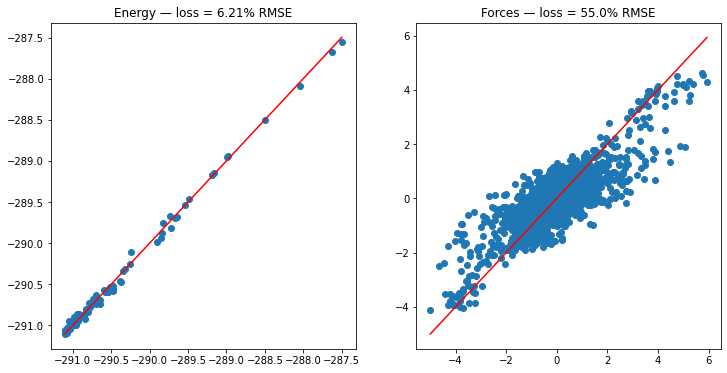

In [17]:
predicted = model.predict(train_ps)

for frame in training_frames:
    frame.positions.grad = None

predicted.backward(-torch.ones_like(predicted), retain_graph=True)
predicted_forces = torch.vstack([frame.positions.grad for frame in training_frames])

parity_plot(train_energies, predicted.detach(), train_forces, predicted_forces)

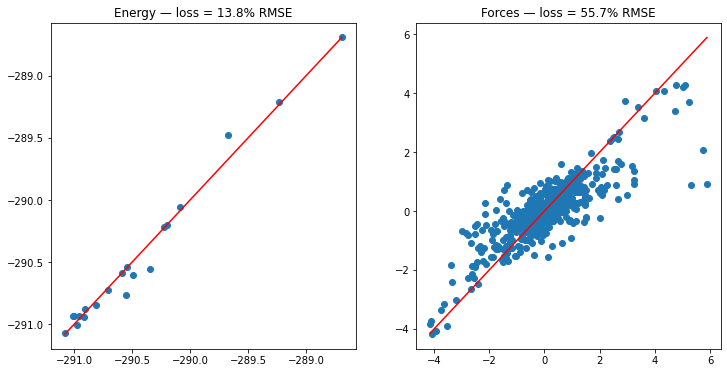

In [18]:
predicted = model.predict(test_ps)

for frame in testing_frames:
    frame.positions.grad = None

predicted.backward(-torch.ones_like(predicted), retain_graph=True)
predicted_forces = torch.vstack([frame.positions.grad for frame in testing_frames])

parity_plot(test_energies, predicted.detach(), test_forces, predicted_forces)

# Sparse kernels

In [19]:
def _select_support_points_for_block(block: Block, n_select: int):
    fps = skcosmo.sample_selection.FPS(n_to_select=n_select)
    selected = fps.fit_transform(invariant_block_to_2d_array(block).detach().numpy())

    return Block(
        torch.tensor(array_2d_to_invariant(selected)), 
        samples=block.samples[fps.selected_idx_],
        symmetric=Labels.single(), 
        features=block.features
    )
    

def select_support_points(ps, n_select):
    if isinstance(n_select, int):
        block = _select_support_points_for_block(ps.block(), n_select)
        return Descriptor(Labels.single(), [block])

    else:
        blocks = []
        for key, value in n_select.items():
            block = _select_support_points_for_block(
                ps.block(**key.as_dict()), 
                n_select=value,
            )
            blocks.append(block)

        return Descriptor(ps.sparse, blocks)

In [20]:
class SparseKernelGapPrecomputedSoap:
    def __init__(self, support_points, zeta, regularizer, jitter=1e-13):
        self.zeta = zeta
        self.jitter = jitter
        self.regularizer = regularizer
        self.support_points = support_points

        self.weights = None

    def fit(self, ps, energies):
        k_mm = self._compute_kernel(self.support_points)
        K_MM = []
        for _, k_mm_block in k_mm:
            K_MM.append(invariant_block_to_2d_array(k_mm_block))
    
        K_MM = torch.block_diag(*K_MM)

        k_nm_per_atom = self._compute_kernel(ps)
        k_nm_per_structure = structure_sum(k_nm_per_atom, sum_features=False)
        
        # TODO: make sure this create an array in the same order as
        # `block_diag` above
        if len(k_nm_per_structure.sparse.names) != 0:
            names = list(k_nm_per_structure.sparse.names)
            k_nm_per_structure.sparse_to_features(names)

        K_NM = invariant_block_to_2d_array(k_nm_per_structure.block()) 
        
        # TODO: include sqrt(n_atoms_per_structure) in the regularizer? 
        regularizer = self.regularizer / energies.std()
        K_NM[:] /= regularizer

        K_MM[np.diag_indices_from(K_MM)] += self.jitter

        self.offset = energies.mean()

        K = K_MM + K_NM.T @ K_NM
        Y = K_NM.T @ (energies - self.offset) / regularizer

        self.weights = torch.linalg.solve(K, Y).detach()


    def predict(self, ps):
        if self.weights is None:
            raise Exception("call fit first")

        k_per_atom = self._compute_kernel(ps)
        k_per_structure = structure_sum(k_per_atom, sum_features=False)
        # TODO: make sure this create an array in the same order as block_diag above
        if len(k_per_structure.sparse.names) != 0:
            names = list(k_per_structure.sparse.names)
            k_per_structure.sparse_to_features(names)

        kernel = invariant_block_to_2d_array(k_per_structure.block())
        
        return kernel @ self.weights.T + self.offset

    def _compute_kernel(self, ps):
        return power(dot(ps, self.support_points), zeta=self.zeta)

In [21]:
support = select_support_points(train_ps, n_select=80)

print(support.block().values.shape)

torch.Size([80, 1, 1512])


In [22]:
model = SparseKernelGapPrecomputedSoap(support_points=support, zeta=2, regularizer=1e-2)

model.fit(train_ps, train_energies)

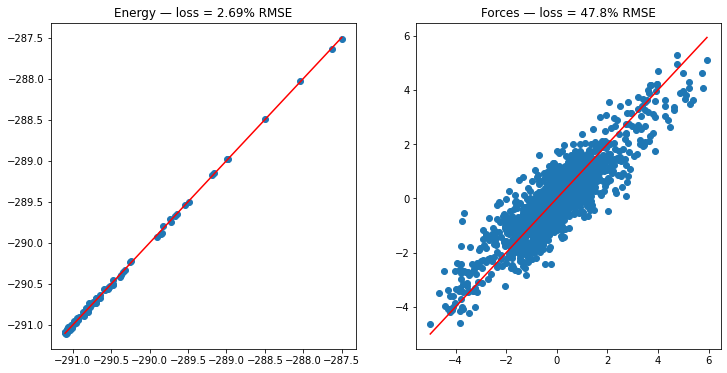

In [23]:
predicted = model.predict(train_ps)

for frame in training_frames:
    frame.positions.grad = None

predicted.backward(-torch.ones_like(predicted), retain_graph=True)
predicted_forces = torch.vstack([frame.positions.grad for frame in training_frames])

parity_plot(train_energies, predicted.detach(), train_forces, predicted_forces)

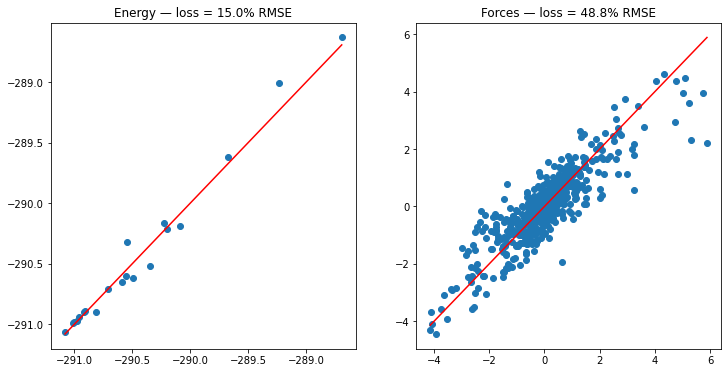

In [24]:
predicted = model.predict(test_ps)

for frame in testing_frames:
    frame.positions.grad = None

predicted.backward(-torch.ones_like(predicted), retain_graph=True)
predicted_forces = torch.vstack([frame.positions.grad for frame in testing_frames])

parity_plot(test_energies, predicted.detach(), test_forces, predicted_forces)

## Sparse kernel with different support point per central species

In [25]:
n_select = {
    center_species: 0
    for center_species in train_ps_per_species.sparse.as_namedtuples()
}

n_select[(1,)] = 30
n_select[(6,)] = 30
n_select[(8,)] = 20

support = select_support_points(train_ps_per_species, n_select=n_select)

In [26]:
model = SparseKernelGapPrecomputedSoap(support_points=support, zeta=2, regularizer=1e-2)

model.fit(train_ps_per_species, train_energies)

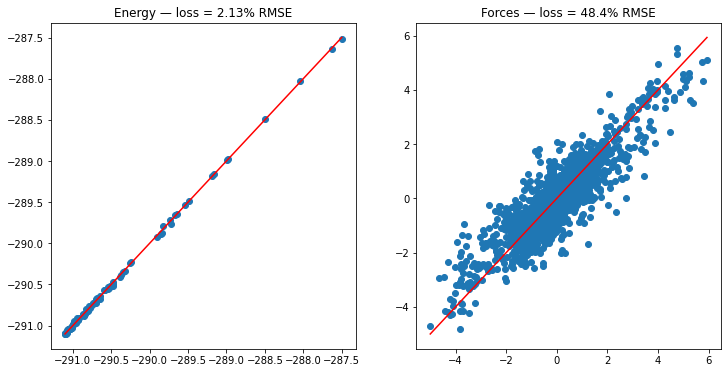

In [27]:
predicted = model.predict(train_ps_per_species)

for frame in training_frames:
    frame.positions.grad = None

predicted.backward(-torch.ones_like(predicted), retain_graph=True)
predicted_forces = torch.vstack([frame.positions.grad for frame in training_frames])

parity_plot(train_energies, predicted.detach(), train_forces, predicted_forces)

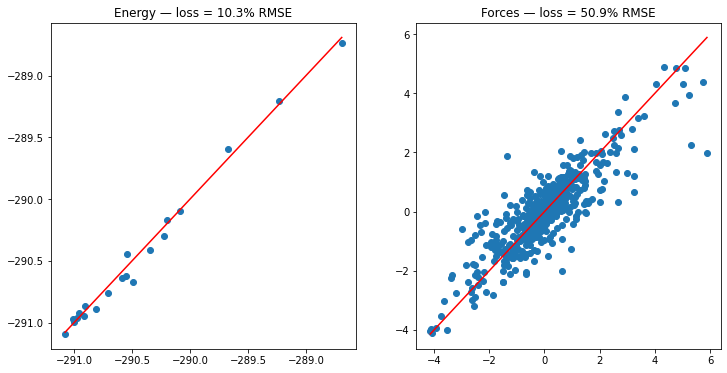

In [28]:
predicted = model.predict(test_ps_per_species)

for frame in testing_frames:
    frame.positions.grad = None

predicted.backward(-torch.ones_like(predicted), retain_graph=True)
predicted_forces = torch.vstack([frame.positions.grad for frame in testing_frames])

parity_plot(test_energies, predicted.detach(), test_forces, predicted_forces)